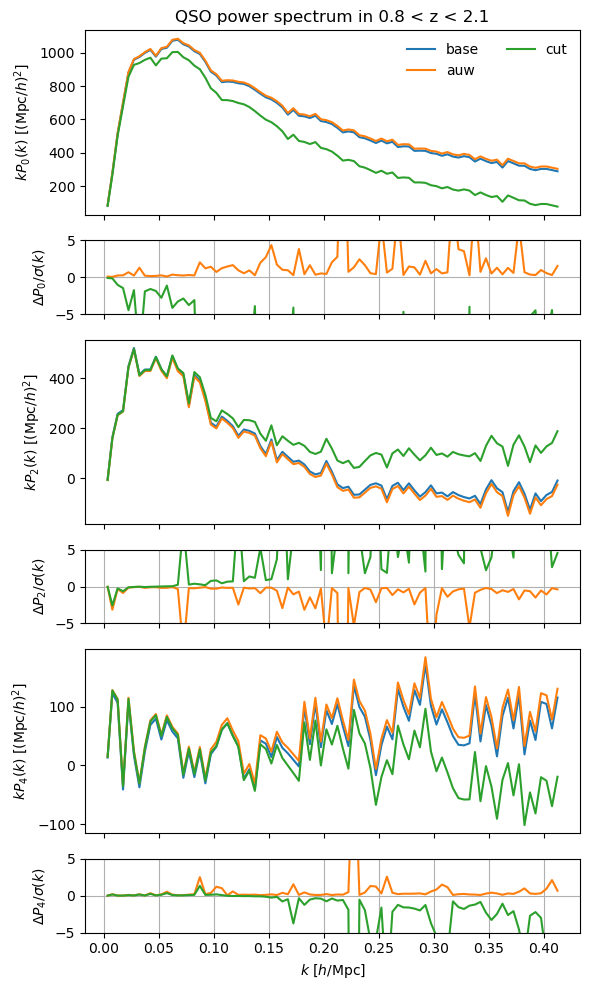

In [30]:
import os
import sys
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types

sys.path.insert(0, '../')
import tools

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

ext = 'png'
kinds = ['angular_upweights', 'mesh2_spectrum', 'mesh3_spectrum'][1:2]

meas_dir = Path(os.getenv('SCRATCH')) / 'clustering-measurements-checks2'

for tracer in ['LRG', 'ELG_LOPnotqso', 'QSO'][2:]:
    for zrange in tools.propose_fiducial('zranges', tracer=tracer):
        imocks = 451 + np.arange(2)
        region = 'NGC'
        kw = dict(meas_dir=meas_dir, version='holi-v1-altmtl', tracer=tracer, region=region)

        def get_mean_cov(kind, rebin=1, **kwargs):
            fns = [tools.get_measurement_fn(kind=kind, zrange=zrange, imock=imock, **kw, **kwargs) for imock in imocks]
            fns = [fn for fn in fns if fn.exists()]
            stats = list(map(types.read, fns))
            sl = slice(0, None, rebin)
            mean = types.mean(stats).select(k=sl)
            cov = None
            if len(fns) > 1: cov = types.cov(stats).at.observable.select(k=sl)
            return mean, cov

        for kind in kinds:
            if kind == 'angular_upweights':

                def get_mean(kind, **kwargs):
                    fns = [tools.get_measurement_fn(kind=kind, imock=imock, **kw, **kwargs) for imock in imocks]
                    fns = [fn for fn in fns if fn.exists()]
                    return types.sum([types.read(fn).get('DD') for fn in fns])

                mean = get_mean(kind)
                fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
                ax.set_title(f'{tracer} angular upweights')
                weight = mean.select(theta=(0., 0.1))
                ax.plot(weight.coords('theta'), weight.value(), linestyle='-')
                ax.grid(True)
                #ax.set_xlim(0., 0.002)
                #ax.set_ylim(0.9, 2.)
                ax.set_xlabel(r'$\theta$ [$\mathrm{deg}$]')
                ax.legend(frameon=False, ncol=2)
                basename = f'check_angular_upweights_{tracer}.{ext}'
                plt.tight_layout()
                fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
                plt.show()

            if kind == 'mesh2_spectrum':
                rebin = 5
                means, covs = {}, {}
                means['base'], covs['base'] = get_mean_cov(kind, rebin=rebin)
                means['auw'], covs['auw'] = get_mean_cov(kind, rebin=rebin, auw=True)
                means['cut'], covs['cut'] = get_mean_cov(kind, rebin=rebin, cut=True)
                versions = list(means)
                version_ref = 'base'
                mean_ref, cov_ref = means[version_ref], covs[version_ref]
                colors = {version: f'C{iversion:d}' for iversion, version in enumerate(versions)}
                ells = mean_ref.ells
                fig, lax = plt.subplots(len(ells) * 2, figsize=(6, 10), sharex=True, gridspec_kw={'height_ratios': [2.5, 1] * len(ells)})
                lax[0].set_title(f'{tracer} power spectrum in {zrange[0]:.1f} < z < {zrange[1]:.1f}')
                for ill, ell in enumerate(ells):
                    ax = lax[2 * ill]
                    ax.set_ylabel(rf'$k P_{ell:d}(k)$ [$(\mathrm{{Mpc}}/h)^2$]')
                    for iversion, version in enumerate(versions):
                        pole = means[version].get(ell)
                        ax.plot(pole.coords('k'), pole.coords('k') * pole.value().real, color=colors[version], linestyle='-', label=version)
                    if ill == 0: ax.legend(frameon=False, ncol=2)
                    ax = lax[2 * ill + 1]
                    ax.set_ylabel(rf'$\Delta P_{ell:d} / \sigma(k)$')
                    ax.grid(True)
                    ax.set_ylim(-5., 5.)
                    for iversion, version in enumerate(versions):
                        if version == version_ref: continue
                        pole = means[version].get(ell)
                        std = cov_ref.at.observable.get(ell).std().real
                        ax.plot(pole.coords('k'), (pole.value() - mean_ref.get(ell).value()).real / std, color=colors[version], linestyle='-')
                lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
                basename = f'comparison_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
                plt.tight_layout()
                fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
                plt.show()

            if kind == 'mesh3_spectrum':
                mean, cov = get_mean_cov(kind)
                ells = mean.ells
                fig, lax = plt.subplots(len(ells), figsize=(6, 4), sharex=True)
                lax[0].set_title(f'{tracer} bispectrum in {zrange[0]:.1f} < z < {zrange[1]:.1f}')
                for ill, ell in enumerate(ells):
                    ax = lax[ill]
                    ax.set_ylabel(rf'$k^2 B_{{{ell[0]:d}{ell[1]:d}{ell[2]:d}}}(k, k)$ [$(\mathrm{{Mpc}}/h)^6$]')
                    pole = mean.get(ell)
                    x = pole.coords('k')[..., 0]
                    ax.plot(x, x**2 * pole.value().real, color='k', linestyle='-')
                basename = f'check_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
                plt.tight_layout()
                fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
                plt.show()
                
        